# Pacoes e classes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from funcoes.buscar_dados import Temperature, Load
from funcoes.equacoes import  tabela_equacoes
from funcoes.graficos import plotar_graficos, grid_graficos, grid_graficos_estacoes, plot_metricas_por_hora
from funcoes.estacao_ano import estacao_do_ano
from funcoes.funcoes_gerais import  trocar_temp
from funcoes.funcoes_teste import treinamento_estado,treinamento_regioes
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import gridstatus as gs
from gridstatus import Ercot
import datetime as dt
import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# credencias
api_key = '1a69aa1efefb4b73a592faf0e2fbe241'
start_date = "2020-01-01"
end_date = "2025-01-01"

In [ ]:
# Temperatura
# temp = Temperature(api_key)
# df_temp = temp.get_df_temp(start_date, end_date)
# df_temp.to_csv('df_temp2.csv')

# # Carga
# load = Load(api_key)
# df_load = load.get_df_load(start_date, end_date)
# df_load.to_csv('df_load2.csv')


# Lendo arquivos baixados pela api
filtrar de 2023/09 até 2024/09 todas as horas da carga

In [3]:
# df_t = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/Área de Trabalho/df_temp.csv')
# df_l = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/Área de Trabalho/df_load.csv')

df_t = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/dados_tcc/df_temp.csv')
df_l = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/dados_tcc/df_load.csv')

In [4]:
# Tratamentos iniciais
for df in [df_l, df_t]:
    df["interval_start_utc"] = pd.to_datetime(df["interval_start_utc"]).dt.tz_localize(None)
    df["interval_end_utc"] = pd.to_datetime(df["interval_end_utc"], utc=True).dt.tz_localize(None)
    df["publish_time_utc"] = pd.to_datetime(df["publish_time_utc"], utc=True).dt.tz_localize(None)
    
df_t = df_t.drop(columns=["Unnamed: 0"], errors="ignore")
df_l = df_l.drop(columns=["Unnamed: 0", "publish_time_utc_load",'publish_time_utc_tf'], errors="ignore")


df_t = df_t[['interval_start_utc', 'interval_end_utc', 'publish_time_utc', 'coast',
        'east', 'far_west', 'north', 'north_central', 'south_central',
        'southern', 'west', 'hour', 'weekday', 'avg_temp_fahrenheit']]

# Merge
df = pd.merge(
    df_l,
    df_t,
    on=["interval_start_utc", "interval_end_utc"],
    how="inner",
    suffixes=['_carga','_tf']
)

df = trocar_temp(df)
df['publish_time_utc_carga'] = pd.to_datetime(df['publish_time_utc_carga'])


hora = dt.time(10, 30) 
df = df[(df['publish_time_utc_carga'].dt.time == hora)]


# Criacao da coluna de temperatura ponderada pela populacao

In [5]:
# Dicionário de população por região
populacao_regioes = {
    'coast': 7077912,
    'east': 1562486,
    'far_west': 513422,
    'north': 1196299,
    'north_central': 9007898,
    'south_central': 4334575,
    'southern': 2337867,
    'west': 644082
}

# Lista das colunas de temperatura
colunas_temp = [f'{regiao}_tc' for regiao in populacao_regioes]

# Calcula o numerador (temperatura * população por região)
numerador = sum(df[col] * populacao_regioes[col.rsplit('_', 1)[0]] for col in colunas_temp)

# Soma total das populações
denominador = sum(populacao_regioes.values())

# Cria a nova coluna de temperatura ponderada
df['temp_ponderada_pop'] = numerador / denominador

# Teste 1
y= f(x,weekday)= ax2 + bx + c⋅weekday + d

In [6]:
tabela1 = treinamento_estado(df, 'avg_temp_celsius', 'sum_load')
tabela1

,hora,equacao,RMSE Treino,R² Treino,RMSE Teste,R² Teste,RMSE Validação,R² Validação
0,0,y = 91.46x² -2470.81x -390.86weekday +55907.42,2138.154912,0.930681,1779.184871,0.949863,2031.612232,0.929672
1,1,y = -2.69x² +679.53x +1518.63weekday +32564.48,5750.576016,0.397007,5023.237968,0.515990,5771.360954,0.317357
2,2,y = 91.08x² -2468.03x -416.54weekday +53881.54,1940.691498,0.917673,1805.155211,0.925524,1893.276114,0.916653
3,3,y = 90.07x² -2417.17x -69.27weekday +52866.13,1891.726232,0.909107,1505.696466,0.938456,2001.234891,0.886578
4,4,y = 89.74x² -2408.67x +471.56weekday +52782.21,1890.352468,0.896386,1495.840068,0.928949,2074.856758,0.861466
5,5,y = 89.16x² -2424.19x +1773.87weekday +53668.81,1970.414672,0.873249,1576.358112,0.907231,2161.582236,0.831709
6,6,y = 84.00x² -2337.09x +3733.15weekday +54759.41,2194.546560,0.825936,1780.728735,0.863668,2325.505076,0.789381
7,7,y = 81.63x² -2295.76x +4285.11weekday +55732.34,2324.638095,0.795911,1933.740444,0.833652,2452.702999,0.760579
8,8,y = 83.15x² -2345.95x +3256.03weekday +57526.91,2224.679008,0.833602,2101.844381,0.852905,1883.294988,0.855331
9,9,y = 88.96x² -2660.06x +2441.38weekday +62318.07,2207.655179,0.883529,2003.623266,0.903744,1959.302789,0.892803


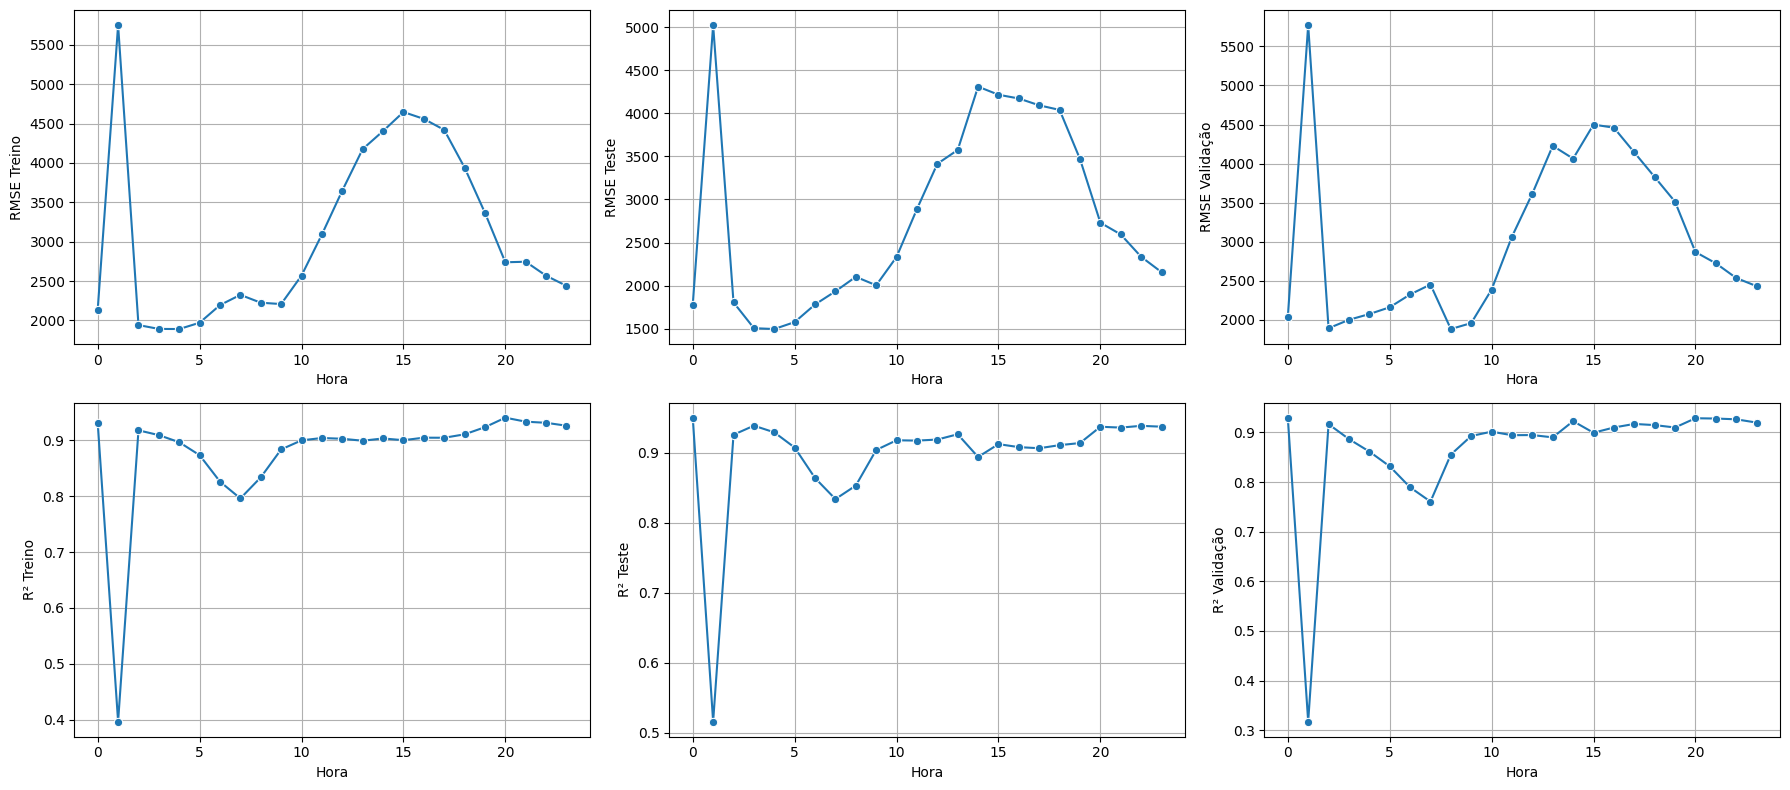

In [7]:
df_resultado_estado1 = treinamento_estado(df, column_x='avg_temp_celsius', column_y='sum_load')
plot_metricas_por_hora(df_resultado_estado1)

# Teste 2

In [8]:
tabela2 = treinamento_estado(df, 'temp_ponderada_pop', 'sum_load')
tabela2

,hora,equacao,RMSE Treino,R² Treino,RMSE Teste,R² Teste,RMSE Validação,R² Validação
0,0,y = 95.53x² -2672.39x -636.64weekday +57969.10,2237.396586,0.924096,1876.688132,0.944218,2289.020171,0.910722
1,1,y = -4.82x² +760.82x +1507.03weekday +31619.77,5847.219074,0.376569,5178.618167,0.485584,5918.528757,0.282099
2,2,y = 93.61x² -2629.78x -543.90weekday +55642.16,2047.163202,0.908391,1977.411761,0.910633,2038.729726,0.903355
3,3,y = 92.54x² -2583.77x -220.76weekday +54709.53,1978.054876,0.900622,1643.552377,0.926671,2230.723411,0.859073
4,4,y = 91.15x² -2544.78x +255.40weekday +54488.04,1981.045670,0.886205,1636.436276,0.914966,2303.025157,0.829322
5,5,y = 90.60x² -2570.20x +1607.60weekday +55498.24,2035.389035,0.864752,1687.915720,0.893636,2362.373591,0.798991
6,6,y = 85.19x² -2476.78x +3500.99weekday +56661.45,2250.747657,0.816906,1865.570661,0.850367,2489.946691,0.758541
7,7,y = 83.74x² -2474.79x +4066.13weekday +57991.94,2330.002593,0.794968,1966.917410,0.827895,2557.281791,0.739727
8,8,y = 86.73x² -2587.11x +3070.16weekday +60331.04,2216.392774,0.834839,1992.304125,0.867837,1938.250663,0.846765
9,9,y = 92.76x² -2909.68x +2264.45weekday +65357.85,2268.368272,0.877035,1988.583011,0.905183,2059.792940,0.881525


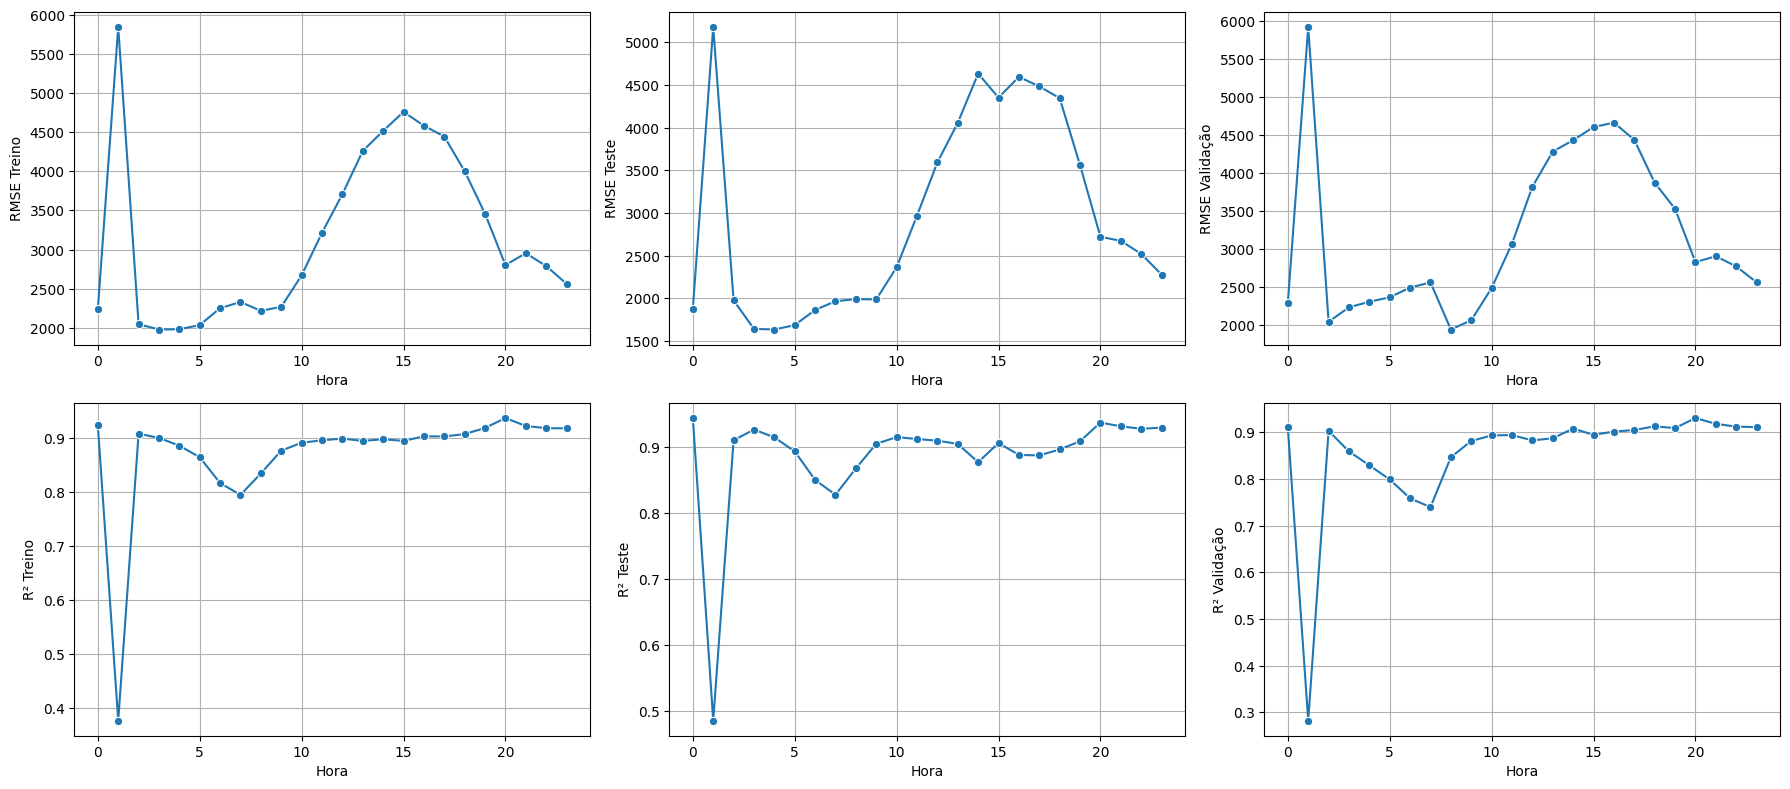

In [9]:
df_resultado_estado2 = treinamento_estado(df, column_x='temp_ponderada_pop', column_y='sum_load')
plot_metricas_por_hora(df_resultado_estado2)

# Teste 3

In [7]:
tabela3 = treinamento_regioes(df)
tabela3

,hora,Equação coast,RMSE coast Treino,R² coast Treino,RMSE coast Teste,R² coast Teste,RMSE coast Validação,R² coast Validação,Equação east,RMSE east Treino,...,R² southern Teste,RMSE southern Validação,R² southern Validação,Equação west,RMSE west Treino,R² west Treino,RMSE west Teste,R² west Teste,RMSE west Validação,R² west Validação
0,0,y = 26.22x² -751.19x +15227.30,790.679255,0.873037,659.070029,0.910780,662.042813,0.901513,y = 3.78x² -109.71x +2119.17,147.100806,...,0.901601,207.833911,0.895551,y = 1.98x² -54.35x +1467.12,110.899211,0.744019,96.695698,0.784152,111.556781,0.724798
1,1,y = -4.33x² +375.63x +5991.43,1490.702950,0.470530,1254.710646,0.615542,1444.961746,0.441427,y = 0.37x² -5.92x +1489.70,254.534573,...,0.630459,464.109162,0.413591,y = 0.59x² -11.67x +1228.63,176.079680,0.252497,150.404917,0.431597,178.636078,0.240642
2,2,y = 23.92x² -678.52x +14208.36,711.575953,0.859468,720.051023,0.848348,650.588624,0.868700,y = 3.66x² -108.01x +2039.01,143.314098,...,0.878059,211.561943,0.849533,y = 2.04x² -56.93x +1446.39,115.369885,0.636177,111.106112,0.590819,117.503683,0.624947
3,3,y = 23.39x² -663.30x +14044.64,733.045474,0.834488,577.482539,0.890589,631.806290,0.857925,y = 3.56x² -104.50x +2000.31,137.577499,...,0.867114,194.710281,0.866711,y = 2.05x² -57.01x +1430.91,110.335091,0.619526,108.126005,0.622319,113.408793,0.618128
4,4,y = 23.03x² -654.15x +14114.06,726.539319,0.821179,572.566255,0.877925,653.595792,0.829173,y = 3.56x² -105.91x +2037.25,135.232355,...,0.863606,185.749160,0.856649,y = 2.04x² -57.04x +1442.78,108.271200,0.578662,107.670625,0.590181,114.201441,0.577306
5,5,y = 23.94x² -697.63x +14935.84,769.975335,0.784752,638.134907,0.826518,705.375433,0.782583,y = 3.60x² -109.16x +2139.50,137.855741,...,0.830312,174.352604,0.848487,y = 1.97x² -56.35x +1486.66,110.142771,0.517418,110.095520,0.557141,117.290719,0.518873
6,6,y = 23.50x² -700.41x +15644.63,867.450694,0.700003,745.356096,0.714158,826.902897,0.669870,y = 3.41x² -106.99x +2271.72,159.772034,...,0.680902,212.863789,0.734136,y = 1.76x² -52.63x +1553.36,123.235906,0.406167,126.675762,0.491084,130.299802,0.444063
7,7,y = 24.84x² -754.46x +16395.92,893.683074,0.677787,785.925734,0.672375,861.129364,0.640983,y = 3.32x² -105.09x +2326.39,162.678675,...,0.614025,230.091343,0.672977,y = 1.70x² -51.90x +1606.93,131.750242,0.385464,143.195579,0.448743,141.479772,0.408911
8,8,y = 24.83x² -760.56x +16703.37,879.270718,0.744753,764.473635,0.794558,716.133368,0.778786,y = 3.31x² -104.47x +2348.06,148.936391,...,0.809453,181.725927,0.819807,y = 1.59x² -46.28x +1588.87,126.448052,0.345874,132.294701,0.444218,119.851022,0.376806
9,9,y = 25.48x² -812.46x +17684.70,923.083764,0.799051,790.677391,0.845928,758.931912,0.833551,y = 3.72x² -122.66x +2562.75,134.122401,...,0.885855,194.200776,0.867709,y = 1.69x² -49.35x +1641.44,122.778309,0.460053,115.511747,0.549230,116.528164,0.492008


In [11]:
def plot_metricas_regioes(df_resultados, tipo='Teste'):
    regioes = ['coast', 'east', 'far_west', 'north', 'north_central', 'south_central', 'southern', 'west']
    fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
    axs = axs.ravel()

    for i, regiao in enumerate(regioes[:6]):  # Pegando 6 regiões pra 2x3
        ax = axs[i]
        ax.plot(df_resultados['hora'], df_resultados[f'RMSE {regiao} {tipo}'], label='RMSE')
        ax.plot(df_resultados['hora'], df_resultados[f'R² {regiao} {tipo}'], label='R²')
        ax.set_title(f"{regiao.capitalize()} - {tipo}")
        ax.legend()
        ax.set_xlabel('Hora')
        ax.set_ylabel('Valor')

    plt.suptitle(f'Métricas por Região - {tipo}', fontsize=16)
    plt.tight_layout()
    plt.show()

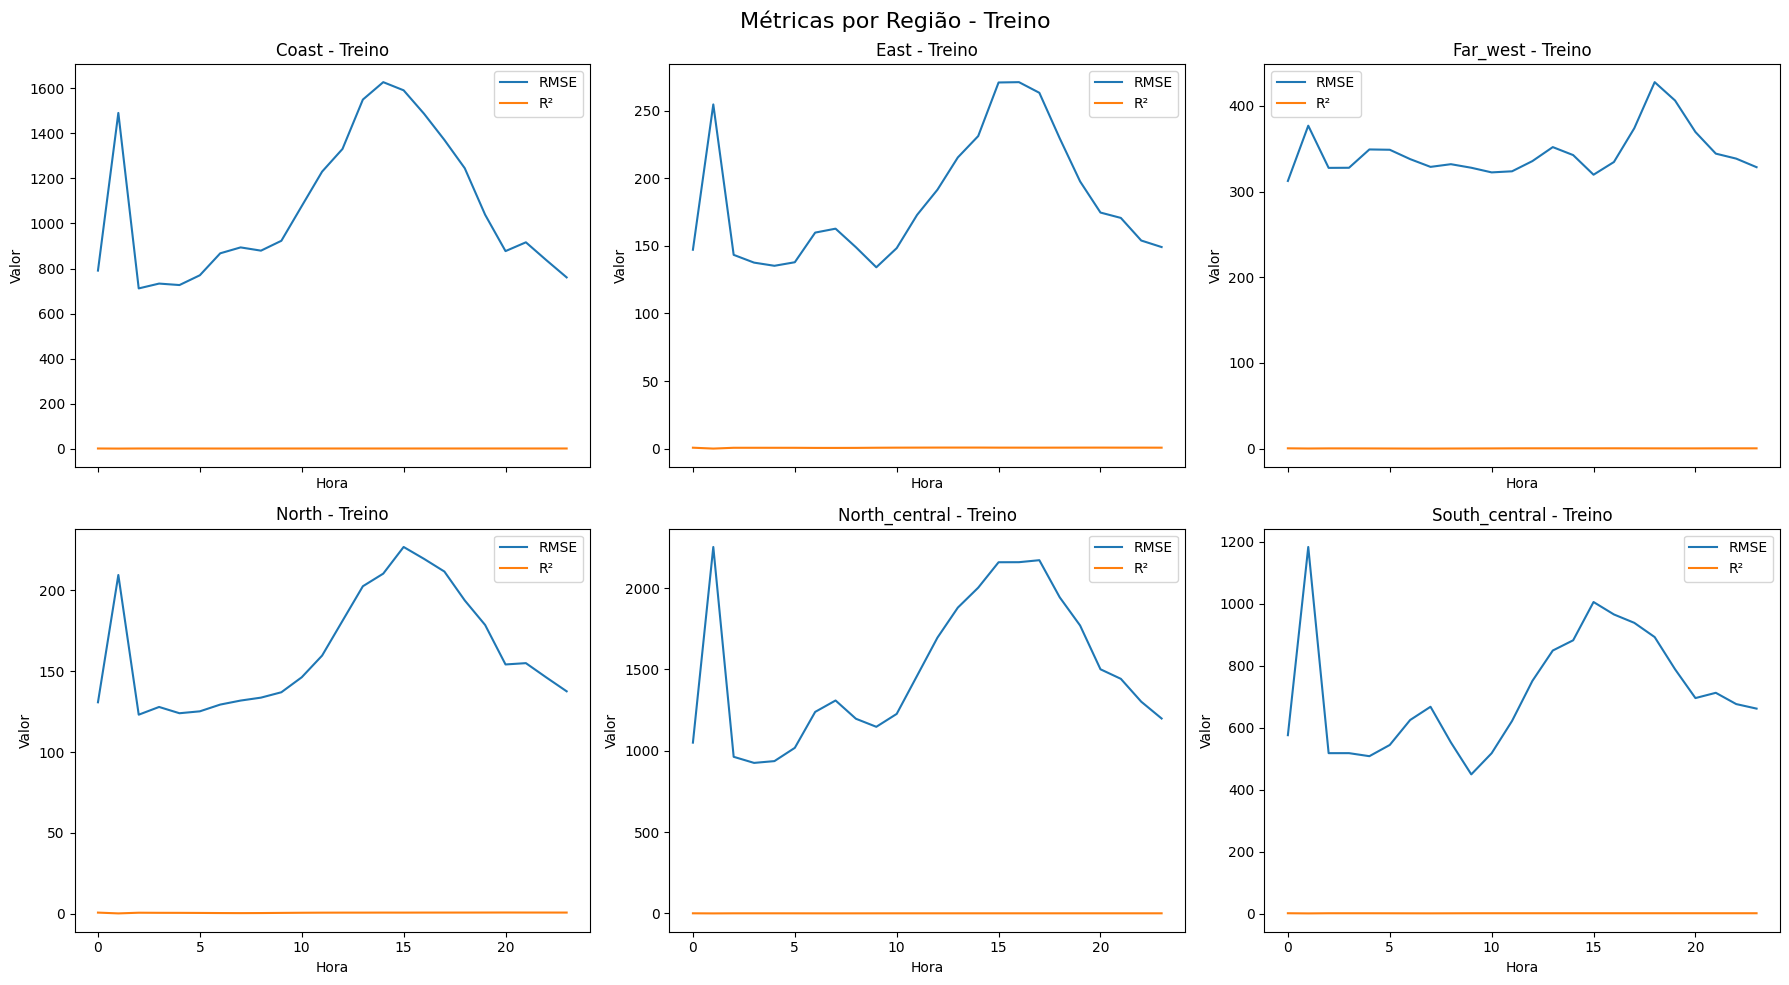

In [13]:
tabela3 = treinamento_regioes(df)
plot_metricas_regioes(tabela3, tipo='Treino')  # Ou 'Treino', 'Validação'

In [14]:
def heatmap_r2(df_resultados, tipo='Validação'):
    regioes = ['coast', 'east', 'far_west', 'north', 'north_central', 'south_central', 'southern', 'west']
    dados_heatmap = []

    for regiao in regioes:
        col_r2 = f'R² {regiao} {tipo}'
        dados_heatmap.append(df_resultados[col_r2].values)

    heatmap_data = pd.DataFrame(dados_heatmap, index=regioes, columns=df_resultados['hora'])

    plt.figure(figsize=(14, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(f'Heatmap R² por Região ({tipo})')
    plt.xlabel('Hora do Dia')
    plt.ylabel('Região')
    plt.show()

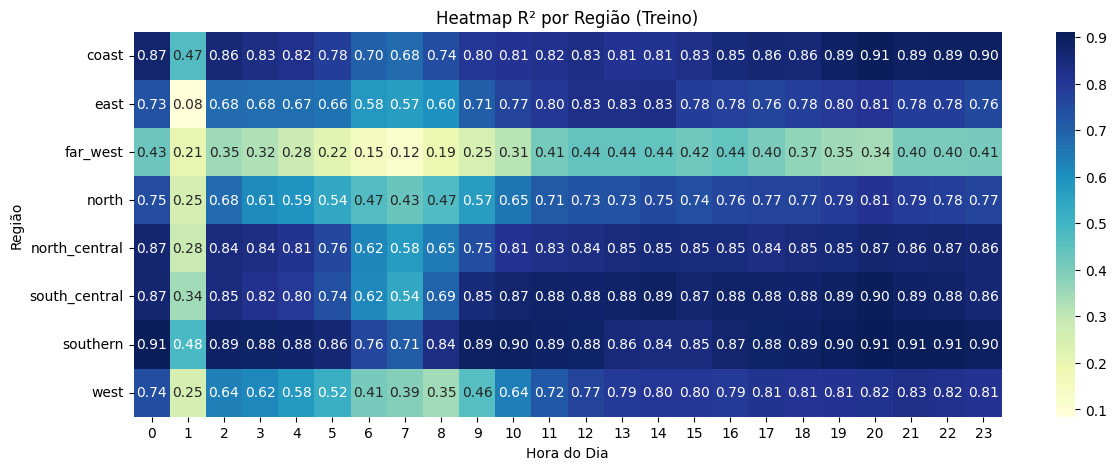

In [15]:
tabela3 = treinamento_regioes(df)
heatmap_r2(tabela3, tipo='Treino')